# Data Pipeline

## 0. Load Required Libraries

In [145]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import joblib
import os
import yaml
import src.util as util
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates


## 1. Load Configuration File

In [146]:
def read_raw_data(config: dict) -> pd.DataFrame:
    # Load and define stock ticker list at IDX
    #stock_list = pd.read_excel(config['raw_dataset_dir'])
    target_stock = config['target_stock']
    feature_stocks = config['feature_stock']

    # Add new column with a value suitable to ticker name at yfinance
    #stock_list['ticker.jk'] = stock_list['Kode'] + config['ticker_ext']

    # Take only the needed column and change it from df to list
    #ticker_list = stock_list['ticker.jk'].tolist()
    
    # Define the date range parameter
    start_date = config['start_date']
    end_date = date.today()
    interval = config['interval_date']

    # Download stock data from yfinance
    target_data = yf.download(target_stock, start=start_date, end=end_date, interval=interval)["Adj Close"]
    feature_data = yf.download(feature_stocks, start=start_date, end=end_date, interval=interval)["Adj Close"]

    # Convert the Series to a DataFrame
    target_data = target_data.reset_index()
    target_data.columns = ['Date', config['target_stock']]
    target_data.set_index('Date', inplace=True)
    
    # return raw dataset
    return target_data, feature_data

In [147]:
def calculate_log_returns(data):
    log_returns = np.log(data) - np.log(data.shift(1))
    return log_returns

In [148]:
config_data = util.load_config()
target_data, feature_data = read_raw_data(config_data)
display(target_data)
display(feature_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  9 of 9 completed


,BMRI.JK
Date,
2022-01-03,3201.196533
2022-01-04,3257.955322
2022-01-05,3189.844727
2022-01-06,3189.844727
2022-01-07,3201.196533
...,...
2023-04-17,5125.000000
2023-04-18,5175.000000
2023-04-26,5200.000000


,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
Date,,,,,,,,,
2022-01-03,212.0,248.0,260.0,123.0,284.0,302.0,78.0,4032.504395,1533.825439
2022-01-04,210.0,240.0,258.0,119.0,288.0,302.0,78.0,4022.857422,1528.909424
2022-01-05,208.0,246.0,256.0,120.0,290.0,302.0,78.0,3907.091553,1533.825439
2022-01-06,196.0,244.0,248.0,120.0,284.0,302.0,78.0,3974.621582,1523.993286
2022-01-07,199.0,244.0,250.0,118.0,290.0,302.0,82.0,4022.857422,1523.993286
...,...,...,...,...,...,...,...,...,...
2023-04-17,191.0,208.0,187.0,118.0,180.0,298.0,80.0,4270.000000,1390.000000
2023-04-18,190.0,208.0,178.0,117.0,175.0,300.0,88.0,4270.000000,1400.000000
2023-04-26,194.0,212.0,190.0,123.0,175.0,300.0,82.0,4400.000000,1405.000000


In [149]:
raw_dataset = pd.concat([target_data, feature_data], axis=1)
raw_dataset['BMRI.JK'].loc['2023-03-30'] = float(5112)



In [150]:
# Save raw dataset & log data to file
util.pickle_dump(raw_dataset, config_data['raw_dataset_path'])

In [151]:
log_data = calculate_log_returns(raw_dataset)
log_data.dropna(inplace=True )

log_data

,BMRI.JK,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
Date,,,,,,,,,,
2022-01-04,0.017575,-0.009479,-0.032790,-0.007722,-0.033061,0.013986,0.000000,0.000000,-0.002395,-0.003210
2022-01-05,-0.021128,-0.009569,0.024693,-0.007782,0.008368,0.006920,0.000000,0.000000,-0.029199,0.003210
2022-01-06,0.000000,-0.059423,-0.008163,-0.031749,0.000000,-0.020907,0.000000,0.000000,0.017136,-0.006431
2022-01-07,0.003552,0.015190,0.000000,0.008032,-0.016807,0.020907,0.000000,0.050010,0.012063,0.000000
2022-01-10,0.000000,0.024815,0.008163,-0.016129,-0.025752,-0.027974,0.000000,-0.012270,-0.016929,0.003221
...,...,...,...,...,...,...,...,...,...,...
2023-04-17,-0.019324,0.010526,-0.019048,-0.005333,-0.016807,0.022473,0.000000,-0.012423,-0.016261,0.003604
2023-04-18,0.009709,-0.005249,0.000000,-0.049325,-0.008511,-0.028171,0.006689,0.095310,0.000000,0.007168
2023-04-26,0.004819,0.020834,0.019048,0.065241,0.050010,0.000000,0.000000,-0.070618,0.029991,0.003565


In [152]:
# Check nan value
log_data.isna().any().sum()

0

In [153]:
# Save raw dataset & log data to file
util.pickle_dump(log_data, config_data['log_dataset_path'])

## 2. Data Definition

## 3. Data Validation

### 3.1 Data type

In [154]:
# Chek data type each variable
log_data.dtypes

BMRI.JK    float64
APII.JK    float64
IKBI.JK    float64
INTD.JK    float64
JKON.JK    float64
KICI.JK    float64
PDES.JK    float64
PGJO.JK    float64
TLKM.JK    float64
ULTJ.JK    float64
dtype: object

In [155]:
# since there are a lot of columns, need to check the dtypes in summarry
# showing that there are only 2 dtypes, datetime & float.
log_data.dtypes.value_counts()

float64    10
dtype: int64

### 3.2 Data Range

In [156]:
log_data.describe()

,BMRI.JK,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,0.001496,-0.000309,-0.000489,-0.001094,-0.000025,-0.001455,-0.000042,0.000156,0.000164,-0.000207
std,0.017266,0.027959,0.024531,0.052142,0.041635,0.025174,0.017891,0.030091,0.015430,0.009815
min,-0.072391,-0.069593,-0.072103,-0.071973,-0.072496,-0.072103,-0.068563,-0.096627,-0.069457,-0.050945
25%,-0.007203,-0.009950,-0.009569,-0.025318,-0.024391,-0.011050,-0.006601,-0.013986,-0.008772,-0.003643
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.009983,0.005391,0.009479,0.009302,0.016667,0.009756,0.000000,0.013245,0.010695,0.003565
max,0.084475,0.236664,0.119801,0.297252,0.182322,0.127000,0.143101,0.095310,0.041196,0.035893


In [157]:
# Check data statistics, since the column qty is a lot, then we summarize the describe feature in following function
def raw_dataset_describe(dataset):

    # Get the date index statistic info
    date_df = pd.Series(dataset.index).describe(include='datetime64', datetime_is_numeric=True)

    df = dataset.describe()
    # Get the minimum value for each row across all columns and convert it to a DataFrame
    row_min_df = df.min(axis=1).to_frame('Min')

    # Get the maximum value for each row across all columns and convert it to a DataFrame
    row_max_df = df.max(axis=1).to_frame('Max')

    # Concatenate the min and max DataFrames horizontally
    result_df = pd.concat([date_df, row_min_df, row_max_df], axis=1)


    return result_df

In [158]:
# Call Dataset statistics
raw_dataset_describe(log_data)

,Date,Min,Max
count,321,321.000000,321.000000
mean,2022-08-31 03:08:24.672897280,-0.001455,0.001496
min,2022-01-04 00:00:00,-0.096627,-0.050945
25%,2022-05-10 00:00:00,-0.025318,-0.003643
50%,2022-09-05 00:00:00,0.000000,0.000000
75%,2022-12-26 00:00:00,0.000000,0.016667
max,2023-04-28 00:00:00,0.035893,0.297252
std,NaN,0.009815,0.052142


### 3.3 Data Dimension

In [159]:
log_data.shape

(321, 10)

## 4. Data Defense

In [160]:
def check_data(input_data, params, print_errors=True):

    error_messages = []
    error_stock_tickers = []
    #input_data = input_data.fillna(0)
    try:
        # Check index data types
        assert input_data.index.dtype == params['datetime_index'], 'an error occurs in index format, should be datetime.'

        # Check index data type & range
        for column in input_data.columns:
            if input_data[column].dtype != 'float64':
                error_messages.append(f"Column ({column}) has a non-float data type")
                error_stock_tickers.append(column)


        if error_messages:
            total_errors = len(error_messages)
            error_summary = f"\nTotal errors: {total_errors} errors out of {len(input_data.columns)}\n"
            raise AssertionError(error_summary + "\n".join(error_messages))
    
    except AssertionError as e:
        if print_errors:
            print(e)
    
    return error_stock_tickers



In [161]:
# Check the error stock in the dataset
check_data(log_data, config_data)

[]

In [162]:
# Found error in stock above (SCPI.JK), which after checking through news and yfinance data,
# it is already delisted since 2013. So this stock should be removed since it is considered
# as an anomaly.
error_stock_tickers = check_data(log_data, config_data, print_errors=False)
log_data.drop(error_stock_tickers, axis=1, inplace=True)

In [163]:
# Recheck the data and found no issue
check_data(log_data, config_data)


[]

In [164]:
util.pickle_dump(raw_dataset, config_data["clean_dataset_path"])


## 5. Stationary Check

In [165]:
"""
#since for time series modelling we need the data to be stationary. 
#we check the statinary of our dataset.



# Define a function to perform the Augmented Dickey-Fuller test
def perform_adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    print("\n")

for column in log_data.columns:
    print(f"Column: {column}")
    
    fig, ax = plt.subplots()
    ax.plot(log_data[column])
    
    # Format the date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 6 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Display the year and month
    fig.autofmt_xdate()  # Rotate and align the date labels
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Time Series - {column}')
    plt.show()

    print("Summary Statistics:")
    split = round(len(log_data) / 2)
    X1, X2 = log_data[column][0:split], log_data[column][split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print(f"Mean: {mean1} vs {mean2}\nVariance: {var1} vs {var2}\n")

    print("Augmented Dickey-Fuller Test:")
    perform_adf_test(log_data[column])
"""

'\n#since for time series modelling we need the data to be stationary. \n#we check the statinary of our dataset.\n\n\n\n# Define a function to perform the Augmented Dickey-Fuller test\ndef perform_adf_test(series):\n    result = adfuller(series)\n    print(f"ADF Statistic: {result[0]}")\n    print(f"p-value: {result[1]}")\n    print("Critical Values:")\n    for key, value in result[4].items():\n        print(f"\t{key}: {value}")\n    print("\n")\n\nfor column in log_data.columns:\n    print(f"Column: {column}")\n    \n    fig, ax = plt.subplots()\n    ax.plot(log_data[column])\n    \n    # Format the date axis\n    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 6 months\n    ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%m-%Y\'))  # Display the year and month\n    fig.autofmt_xdate()  # Rotate and align the date labels\n    \n    plt.xlabel(\'Date\')\n    plt.ylabel(\'Value\')\n    plt.title(f\'Time Series - {column}\')\n    plt.show()\n\n   

Column: BMRI.JK
Column: APII.JK
Column: IKBI.JK
Column: INTD.JK
Column: JKON.JK
Column: KICI.JK
Column: PDES.JK
Column: PGJO.JK
Column: TLKM.JK
Column: ULTJ.JK


/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_57979/1011704646.py:49: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_57979/1011704646.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


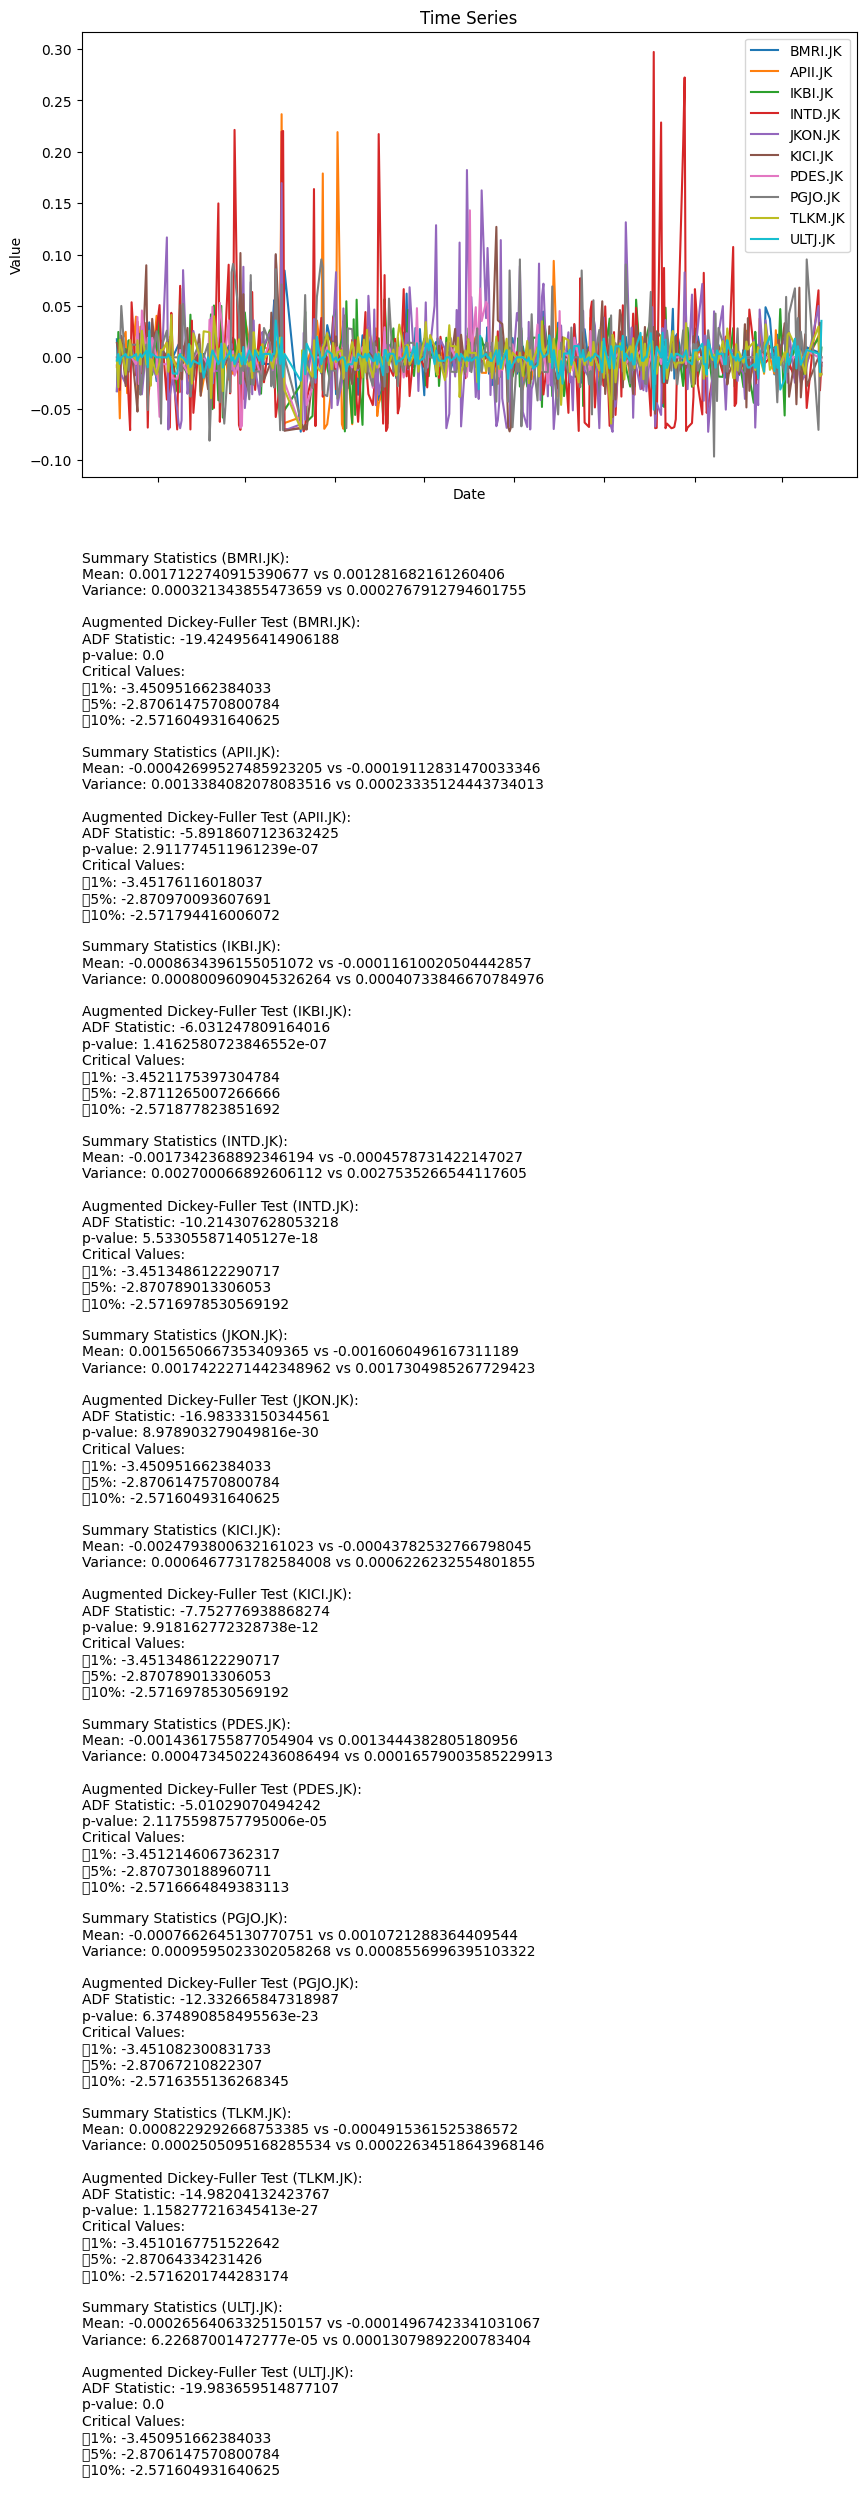

In [166]:
# Define a function to perform the Augmented Dickey-Fuller test
def perform_adf_test(series):
    result = adfuller(series)
    adf_output = f"ADF Statistic: {result[0]}\np-value: {result[1]}\nCritical Values:"
    for key, value in result[4].items():
        adf_output += f"\n\t{key}: {value}"
    return adf_output

# Create a figure with two subplots (one for the plot and one for the text)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 2]})

# Initialize the text string
text_str = ""

# Iterate through each column and plot the time series
for column in log_data.columns:
    print(f"Column: {column}")
    ax1.plot(log_data[column], label=column)
    
    # Format the date axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 2 months
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Display the year and month
    fig.autofmt_xdate()  # Rotate and align the date labels
    
    ax1.set(xlabel='Date', ylabel='Value', title=f'Time Series')

    split = round(len(log_data) / 2)
    X1, X2 = log_data[column][0:split], log_data[column][split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    
    summary_stats = f"Summary Statistics ({column}):"
    summary_stats += f"\nMean: {mean1} vs {mean2}\nVariance: {var1} vs {var2}"
    
    adf_test_results = f"\n\nAugmented Dickey-Fuller Test ({column}):"
    adf_test_results += f"\n{perform_adf_test(log_data[column])}\n"
    
    # Update the text string with summary stats and ADF test results
    text_str += summary_stats + adf_test_results + "\n"

# Add legend to the plot
ax1.legend()

# Add the text string to the lower subplot
ax2.axis('off')
ax2.text(0, 1, text_str, transform=ax2.transAxes, fontsize=10, va='top')

# Display the figure with the plot and the text
plt.tight_layout()
plt.show()


#### Summary Statistics:

- The differences in mean and variance between the two halves are relatively small, which might suggest that the time series could be stationary. However, this is not a definitive conclusion, and we need to rely on the results of the Augmented Dickey-Fuller test for a more accurate determination.

- we divided the data into two halves to compute summary statistics simply as a quick way to examine if there are significant differences in mean and variance between two different time periods within the time series. This method is not as robust as the Augmented Dickey-Fuller test, but it can give a rough idea about the stationarity of the time series.

#### Augmented Dickey Fuller Test:
- In this case, the ADF statistic is less than the critical values at all significance levels (1%, 5%, 10%). The p-value is also less than a commonly used significance level of 0.05. Based on these results, we can reject the null hypothesis and conclude that the time series is stationary.

- 1% significance level: This is a stringent level that indicates a 1% risk of rejecting the null hypothesis when it is actually true. In other words, there's a 99% confidence level that the decision to reject the null hypothesis is correct.
- 5% significance level: This is a commonly used level that represents a 5% risk of rejecting the null hypothesis when it is true. This means there's a 95% confidence level that the decision to reject the null hypothesis is correct.
- 10% significance level: This level is less strict, with a 10% risk of rejecting the null hypothesis when it is true. In this case, there's a 90% confidence level that the decision to reject the null hypothesis is correct.

- By providing critical values for each of these significance levels, the ADF test allows you to decide which level of confidence is appropriate for your specific analysis. A lower significance level (e.g., 1%) requires stronger evidence against the null hypothesis than a higher significance level (e.g., 10%).

##### In summary, both the summary statistics and the Augmented Dickey-Fuller test suggest that the time series is stationary.

In [167]:
#adjust the lagging:
#log_data.iloc[:,1:] = log_data.iloc[:,1:].shift(1)
#log_data.dropna(inplace=True)  

In [168]:
util.pickle_dump(log_data, config_data["clean_dataset_path"])


## 5. Data Splitting

### 5.1 Time Series Split

In [169]:
def split_data(data, train_ratio, validation_ratio, params):
    train_size = int(len(data)*train_ratio)
    val_size = int(len(data)*validation_ratio)

    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size + val_size:]

    # Split feature and target columns for train, test, and validation sets
    feature_columns = data.drop([params['target_stock']], axis=1).columns
    target_column = params['target_stock']
    X_train, y_train = train_data[feature_columns], train_data[target_column]
    X_val, y_val = val_data[feature_columns], val_data[target_column]
    X_test, y_test = test_data[feature_columns], test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [170]:
# Split feature and target columns for train, test, and validation sets

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data=log_data, train_ratio=0.8, validation_ratio=0.1, params=config_data)

print("TRAIN Set:")
display(X_train, display_id='X_train')
display(y_train, display_id='y_train')

print("VALIDATION Set:")
display(X_val, display_id='X_val')
display(y_val, display_id='y_val')

print("TEST Set:")
display(X_test, display_id='X_test')
display(y_test, display_id='y_test')





TRAIN Set:


,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
Date,,,,,,,,,
2022-01-04,-0.009479,-0.032790,-0.007722,-0.033061,0.013986,0.0,0.000000,-0.002395,-0.003210
2022-01-05,-0.009569,0.024693,-0.007782,0.008368,0.006920,0.0,0.000000,-0.029199,0.003210
2022-01-06,-0.059423,-0.008163,-0.031749,0.000000,-0.020907,0.0,0.000000,0.017136,-0.006431
2022-01-07,0.015190,0.000000,0.008032,-0.016807,0.020907,0.0,0.050010,0.012063,0.000000
2022-01-10,0.024815,0.008163,-0.016129,-0.025752,-0.027974,0.0,-0.012270,-0.016929,0.003221
...,...,...,...,...,...,...,...,...,...
2023-01-10,0.000000,0.000000,-0.044452,0.028438,-0.024815,0.0,0.000000,0.010499,0.024015
2023-01-11,-0.005038,-0.048319,0.087011,0.009302,0.014963,0.0,0.000000,0.010390,-0.024015
2023-01-12,0.000000,0.048319,-0.068993,0.036368,0.000000,0.0,0.000000,-0.002587,0.017212


Date
2022-01-04    0.017575
2022-01-05   -0.021128
2022-01-06    0.000000
2022-01-07    0.003552
2022-01-10    0.000000
                ...   
2023-01-10   -0.047377
2023-01-11   -0.035669
2023-01-12    0.027550
2023-01-13   -0.002721
2023-01-16    0.013532
Name: BMRI.JK, Length: 256, dtype: float64

VALIDATION Set:


,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
Date,,,,,,,,,
2023-01-17,0.000000,0.000000,-0.068629,0.008811,0.015114,0.000000,0.012903,0.025642,0.000000
2023-01-18,0.000000,0.000000,-0.067823,0.000000,-0.010050,0.000000,0.000000,-0.005076,-0.003442
2023-01-19,0.005063,0.000000,-0.060259,0.017392,0.020001,0.000000,-0.012903,-0.010230,0.003442
2023-01-20,-0.010152,0.018519,0.000000,0.000000,-0.014963,0.000000,-0.026317,-0.005155,0.003431
2023-01-24,0.005089,-0.027909,0.206863,0.000000,-0.005038,0.000000,0.026317,-0.005181,0.000000
2023-01-25,0.000000,0.000000,0.272415,0.082692,-0.005063,0.000000,0.000000,-0.002601,0.003419
2023-01-26,-0.005089,-0.028710,-0.071744,0.038915,-0.010204,-0.006601,0.000000,0.033294,0.006803
2023-01-27,0.000000,0.028710,-0.068403,-0.031010,0.000000,0.000000,0.000000,-0.002522,-0.003396
2023-01-30,0.000000,-0.028710,-0.063949,0.061088,-0.010309,0.000000,-0.026317,0.000000,-0.006826


Date
2023-01-17    0.047253
2023-01-18   -0.020726
2023-01-19    0.020726
2023-01-20    0.022815
2023-01-24   -0.007547
2023-01-25   -0.020409
2023-01-26    0.012804
2023-01-27    0.020152
2023-01-30   -0.007509
2023-01-31    0.000000
2023-02-01   -0.025447
2023-02-02    0.002574
2023-02-03    0.020357
2023-02-06   -0.005050
2023-02-07    0.029927
2023-02-08    0.002454
2023-02-09    0.004890
2023-02-10    0.004866
2023-02-13    0.004843
2023-02-14    0.002413
2023-02-15   -0.014563
2023-02-16   -0.004902
2023-02-17    0.012210
2023-02-20   -0.002430
2023-02-21   -0.007326
2023-02-22   -0.019803
2023-02-23    0.007472
2023-02-24    0.004951
2023-02-27    0.002466
2023-02-28   -0.014889
2023-03-01    0.009950
2023-03-02    0.012300
Name: BMRI.JK, dtype: float64

TEST Set:


,APII.JK,IKBI.JK,INTD.JK,JKON.JK,KICI.JK,PDES.JK,PGJO.JK,TLKM.JK,ULTJ.JK
Date,,,,,,,,,
2023-03-03,-0.005063,0.000000,-0.015346,-0.007782,-0.016261,0.000000,-0.013986,0.005141,-0.003284
2023-03-06,-0.015346,-0.028988,-0.005168,-0.015748,0.000000,0.000000,0.000000,-0.005141,0.000000
2023-03-07,-0.015585,0.028988,0.000000,-0.040491,0.032261,0.000000,-0.014185,0.000000,0.006557
2023-03-08,0.025841,-0.009569,-0.015666,-0.016667,-0.048790,0.000000,0.000000,0.015346,-0.006557
2023-03-09,-0.005115,0.019048,-0.005277,0.024898,0.038152,0.000000,0.000000,0.007585,-0.009917
2023-03-10,-0.005141,-0.019048,0.046520,-0.024898,-0.032612,0.000000,0.000000,0.010025,-0.010017
2023-03-13,-0.015585,-0.044233,0.010050,0.016667,0.005510,0.000000,0.000000,0.014852,-0.006734
2023-03-14,-0.015831,0.024815,-0.035627,-0.068403,-0.011050,0.000000,0.000000,-0.012361,-0.010187
2023-03-15,-0.010695,0.000000,0.000000,-0.026907,-0.016807,-0.006689,0.000000,-0.002491,0.003407


Date
2023-03-03   -0.017263
2023-03-06    0.007435
2023-03-07    0.004926
2023-03-08    0.009780
2023-03-09    0.016888
2023-03-10   -0.007203
2023-03-13   -0.002413
2023-03-14   -0.041930
2023-03-15    0.012516
2023-03-16   -0.020101
2023-03-17    0.025064
2023-03-20   -0.009950
2023-03-21    0.048790
2023-03-24    0.037387
2023-03-27   -0.016593
2023-03-28   -0.007380
2023-03-29    0.021979
2023-03-30   -0.012249
2023-03-31    0.009830
2023-04-03    0.019185
2023-04-04   -0.011948
2023-04-05    0.004796
2023-04-06   -0.009615
2023-04-10   -0.014599
2023-04-11    0.000000
2023-04-12    0.009756
2023-04-13   -0.004866
2023-04-14    0.019324
2023-04-17   -0.019324
2023-04-18    0.009709
2023-04-26    0.004819
2023-04-27    0.000000
2023-04-28   -0.004819
Name: BMRI.JK, dtype: float64

<DisplayHandle display_id=y_test>

In [171]:
util.pickle_dump(X_train, config_data["train_set_path"][0])
util.pickle_dump(y_train, config_data["train_set_path"][1])

util.pickle_dump(X_val, config_data["valid_set_path"][0])
util.pickle_dump(y_val, config_data["valid_set_path"][1])

util.pickle_dump(X_test, config_data["test_set_path"][0])
util.pickle_dump(y_test, config_data["test_set_path"][1])